---
# A novel optimal approach towards classification of skin lesions
---
## **Hyperparameter tuning using Harris-Hawks Optimization**
---

## Importing the Libraries

In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer, InputSpec
import keras.layers as kl
from glob import glob
import seaborn as sns
import csv
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate, Dense, Conv2D, MaxPooling2D, Flatten, Input, Activation, add, AveragePooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score, classification_report, confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
!pip install mealpy -q
from mealpy.optimizer import Optimizer
from mealpy import FloatVar, StringVar, HHO
from keras.optimizers import Adam, Adagrad, RMSprop, SGD

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.3/386.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 32.8 MB/s eta 0:00:00


## Extracting the dataset from zip file

In [ ]:
from zipfile import ZipFile
filename="./HAM10000.zip"
with ZipFile(filename,'r') as zip:
  zip.extractall()
  print("Zip extracted.")

Zip extracted.


## Exploratory Data Analysis (EDA)

In [ ]:
data_pd = pd.read_csv('./HAM10000_metadata.csv')
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
df_count = data_pd.groupby('lesion_id').count()
df_count.head()

,image_id,dx,dx_type,age,sex,localization
lesion_id,,,,,,
HAM_0000000,2,2,2,2,2,2
HAM_0000001,1,1,1,1,1,1
HAM_0000002,3,3,3,3,3,3
HAM_0000003,1,1,1,1,1,1
HAM_0000004,1,1,1,1,1,1


In [ ]:
df_count = df_count[df_count['dx'] == 1]
df_count.reset_index(inplace=True)

In [ ]:
def duplicates(x):
    unique = set(df_count['lesion_id'])
    if x in unique:
        return 'no'
    else:
        return 'duplicates'

In [ ]:
data_pd['is_duplicate'] = data_pd['lesion_id'].apply(duplicates)
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,duplicates


In [ ]:
df_ham = data_pd[data_pd['is_duplicate'] == 'no']

## Functions to count, and plot image-count histograms

In [ ]:
def count_images_in_subfolders(root_folder):
    image_counts = {}

    for foldername, subfolders, filenames in os.walk(root_folder):
        folder_name = os.path.basename(foldername)  # Extract the subfolder name
        for filename in filenames:
            # Check if the file has a common image extension (you can customize this list)
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                image_counts[folder_name] = image_counts.get(folder_name, 0) + 1
    image_counts = dict(sorted(image_counts.items()))
    return image_counts

In [ ]:
def plot_histogram(image_counts, title):
    folders = list(image_counts.keys())
    counts = list(image_counts.values())
    plt.bar(folders, counts, color='blue')
    plt.xlabel('Class')
    plt.ylabel('Number of images')
    plt.title(title)
    plt.show()

## Train-test split

In [ ]:
train_df, temp_df = train_test_split(df_ham, test_size=0.2, stratify=df_ham['dx'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['dx'])

In [ ]:
def identify_train_test(x):
    train_data = set(train_df['image_id'])
    val_data = set(val_df['image_id'])
    test_data = set(test_df['image_id'])
    if str(x) in train_data:
        return 'train'
    elif str(x) in val_data:
        return 'val'
    else:
        return 'test'

In [ ]:
train_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
4502,HAM_0002948,ISIC_0030927,nv,follow_up,40.0,female,lower extremity,no
5267,HAM_0003203,ISIC_0029421,nv,follow_up,50.0,female,trunk,no
4867,HAM_0004577,ISIC_0027134,nv,follow_up,65.0,male,trunk,no
5200,HAM_0006951,ISIC_0030482,nv,follow_up,45.0,male,trunk,no
6620,HAM_0001682,ISIC_0026630,nv,follow_up,50.0,male,trunk,no


In [ ]:
val_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
8162,HAM_0003099,ISIC_0025734,nv,histo,25.0,male,back,no
2565,HAM_0003593,ISIC_0027478,bcc,histo,40.0,male,back,no
6541,HAM_0003103,ISIC_0031921,nv,follow_up,40.0,female,trunk,no
3040,HAM_0000758,ISIC_0031974,nv,follow_up,45.0,male,lower extremity,no
8072,HAM_0000348,ISIC_0028290,nv,histo,35.0,male,back,no


In [ ]:
test_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
5577,HAM_0003065,ISIC_0031879,nv,follow_up,85.0,male,back,no
4428,HAM_0007565,ISIC_0028241,nv,follow_up,70.0,male,trunk,no
4933,HAM_0003719,ISIC_0028046,nv,follow_up,45.0,male,lower extremity,no
2746,HAM_0005599,ISIC_0030511,bcc,histo,70.0,female,back,no
4587,HAM_0001822,ISIC_0031244,nv,follow_up,40.0,female,hand,no


In [ ]:
# Image id of train and test images
train_list = list(train_df['image_id'])
val_list = list(val_df['image_id'])
test_list = list(test_df['image_id'])

In [ ]:
print('Before Augmentation')
print(f'Number of train images: {len(train_list)}')
print(f'Number of validation images: {len(val_list)}')
print(f'Number of test images: {len(test_list)}')

Before Augmentation
Number of train images: 4411
Number of validation images: 551
Number of test images: 552


In [ ]:
# Set the image_id as the index in data_pd
data_pd.set_index('image_id', inplace=True)

## Organizing the dataset into folders

In [ ]:
base_dir = './HAM10000/'

In [ ]:
train_dir = os.path.join(base_dir, 'train_dir')
val_dir = os.path.join(base_dir, 'val_dir')
test_dir = os.path.join(base_dir, 'test_dir')

In [ ]:
os.mkdir(train_dir)
os.mkdir(val_dir)
os.mkdir(test_dir)

In [ ]:
classes = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

In [ ]:
for c in classes:
    os.mkdir(train_dir + '/' + c)
    os.mkdir(val_dir + '/' + c)
    os.mkdir(test_dir + '/' + c)

In [ ]:
for image in train_list:
    file_name = image + '.jpg'
    label = data_pd.loc[image, 'dx'].upper()

    # path of source image
    source = os.path.join(base_dir, file_name)

    # moving the image from the source to target directory
    target = os.path.join(train_dir, label, file_name)

    shutil.move(source, target)

In [ ]:
for image in val_list:
    file_name = image + '.jpg'
    label = data_pd.loc[image, 'dx'].upper()

    # path of source image
    source = os.path.join(base_dir, file_name)

    # moving the image from the source to target directory
    target = os.path.join(val_dir, label, file_name)

    shutil.move(source, target)

In [ ]:
for image in test_list:
    file_name = image+'.jpg'
    label = data_pd.loc[image, 'dx'].upper()

    # path of source image
    source = os.path.join(base_dir, file_name)

    # moving the image from the source to target directory
    target = os.path.join(test_dir, label, file_name)

    shutil.move(source, target)

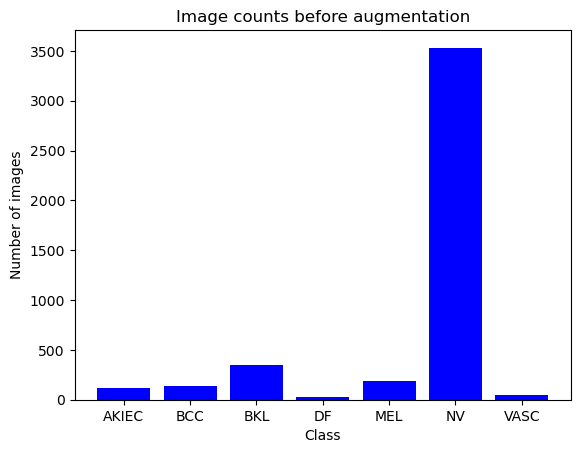

In [ ]:
root_folder = "./HAM10000/train_dir"
image_counts = count_images_in_subfolders(root_folder)
plot_histogram(image_counts, "Image counts before augmentation")

In [ ]:
classes = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

# Augmenting images and storing them in temporary directories
for img_class in classes:

    #creating temporary directories
    # creating a base directory
    aug_dir = './HAM10000/aug_dir'
    os.mkdir(aug_dir)
    # creating a subdirectory inside the base directory for images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    img_list = os.listdir('./HAM10000/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir
    for file_name in img_list:

        # path of source image in training directory
        source = os.path.join('./HAM10000/train_dir/' + img_class, file_name)

        # creating a target directory to send images
        target = os.path.join(img_dir, file_name)

        # copying the image from the source to target file
        shutil.copyfile(source, target)

    # Temporary augumented dataset directory.
    source_path = aug_dir

    # Augmented images will be saved to training directory
    save_path = './HAM10000/train_dir/' + img_class

    # Creating Image Data Generator to augment images
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(source_path,
                                              save_to_dir=save_path,
                                              save_format='jpg',
                                              target_size=(224, 224),
                                              batch_size=batch_size)

    # Generate the augmented images
    aug_images = 8000
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((aug_images - num_files) / batch_size))

    # creating 8000 augmented images per class
    for i in range(0, num_batches):
        images, labels = next(aug_datagen)

    # delete temporary directory
    shutil.rmtree('./HAM10000/aug_dir')

Found 121 images belonging to 1 classes.
Found 140 images belonging to 1 classes.
Found 352 images belonging to 1 classes.
Found 31 images belonging to 1 classes.
Found 184 images belonging to 1 classes.
Found 3532 images belonging to 1 classes.
Found 51 images belonging to 1 classes.


In [ ]:
base_dir = './HAM10000'
train_path = os.path.join(base_dir, 'train_dir')
val_path = os.path.join(base_dir, 'val_dir')
test_path = os.path.join(base_dir, 'test_dir')
batch_size=16

In [ ]:
datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.regnet.preprocess_input)

In [ ]:
image_size = 224

In [ ]:
print("Train Images: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

Train Images: 
Found 45665 images belonging to 7 classes.


In [ ]:
print("Validation Images: ")
val_batches = datagen.flow_from_directory(directory=val_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)

Validation Images: 
Found 551 images belonging to 7 classes.


In [ ]:
print("Test Images: ")
test_batches = datagen.flow_from_directory(directory=test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)

Test Images: 
Found 552 images belonging to 7 classes.


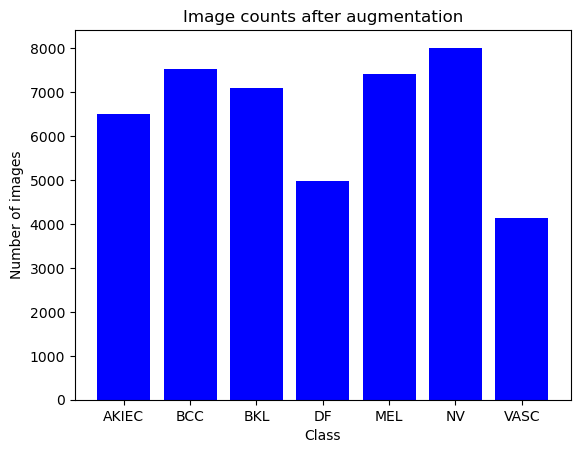

In [ ]:
root_folder = "./HAM10000/train_dir"
image_counts = count_images_in_subfolders(root_folder)
plot_histogram(image_counts, "Image counts after augmentation")

## Model creation

In [ ]:
regnet = tf.keras.applications.regnet.RegNetY032(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
)

# Exclude the last 3 layers of the model.
conv = regnet.layers[-3].output

## Soft Attention Layer

In [ ]:
class SoftAttention(Layer):
    def __init__(self, ch, m, concat_with_x=False, aggregate=False, **kwargs):
        # Initializing SoftAttention layer with parameters:
        # ch: Number of channels
        # m: Number of attention heads
        # concat_with_x: Whether to concatenate scaled features with original features
        # aggregate: Whether to aggregate attention maps across channels
        self.channels = int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x
        super(SoftAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        # Building the SoftAttention layer
        self.i_shape = input_shape

        # Define kernel shape for 3D convolution
        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads)  # DHWC

        # Define output shapes for attention maps and features
        self.out_attention_maps_shape = input_shape[0:1] + (self.multiheads,) + input_shape[1:-1]
        if self.aggregate_channels == False:
            self.out_features_shape = input_shape[:-1] + (input_shape[-1] + (input_shape[-1] * self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1] + (input_shape[-1] * 2,)
            else:
                self.out_features_shape = input_shape

        # Initialize convolutional kernel and bias
        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                              initializer='he_uniform',
                                              name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                            initializer='zeros',
                                            name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):
        # Define operations performed during the call of SoftAttention layer

        # Expand dimensions of input tensor
        exp_x = K.expand_dims(x, axis=-1)

        # Perform 3D convolution
        c3d = K.conv3d(exp_x,
                       kernel=self.kernel_conv3d,
                       strides=(1, 1, self.i_shape[-1]),
                       padding='same',
                       data_format='channels_last')
        conv3d = K.bias_add(c3d, self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        # Permute dimensions for further processing
        conv3d = K.permute_dimensions(conv3d, pattern=(0, 4, 1, 2, 3))
        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d, shape=(-1, self.multiheads, self.i_shape[1] * self.i_shape[2]))

        # Apply softmax to obtain attention maps
        softmax_alpha = K.softmax(conv3d, axis=-1)
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1], self.i_shape[2]))(softmax_alpha)

        if self.aggregate_channels == False:
            # Expand dimensions and permute for further processing
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha, pattern=(0, 2, 3, 1, 4))
            x_exp = K.expand_dims(x, axis=-2)

            # Multiply to obtain scaled features
            u = kl.Multiply()([exp_softmax_alpha, x_exp])
            u = kl.Reshape(target_shape=(self.i_shape[1], self.i_shape[2], u.shape[-1] * u.shape[-2]))(u)
        else:
            # Aggregate attention maps and multiply to obtain scaled features
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha, pattern=(0, 2, 3, 1))
            exp_softmax_alpha = K.sum(exp_softmax_alpha, axis=-1)
            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)
            u = kl.Multiply()([exp_softmax_alpha, x])

        if self.concat_input_with_scaled:
            # Concatenate scaled features with original features
            o = kl.Concatenate(axis=-1)([u, x])
        else:
            o = u

        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape):
        # Define output shapes
        return [self.out_features_shape, self.out_attention_maps_shape]

    def get_config(self):
        # Get configuration
        return super(SoftAttention, self).get_config()

In [ ]:
attention_layer, map2 = SoftAttention(aggregate=True, m=16, concat_with_x=False, ch=int(conv.shape[-1]), name='soft_attention')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv, attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)

In [ ]:
# Modifying the original head of RegNetY032
output = GlobalAveragePooling2D()(conv)
output = Dense(512, activation='relu')(output)
output = Dropout(0.5)(output)
output = Dense(7, activation='softmax')(output)

In [ ]:
hhoregsanet = Model(inputs=regnet.input, outputs=output)

In [ ]:
hhoregsanet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 regnety032_prestem_rescali  (None, 224, 224, 3)          0         ['input_2[0][0]']             
 ng (Rescaling)                                                                                   
                                                                                                  
 regnety032_stem_conv (Conv  (None, 112, 112, 32)         864       ['regnety032_prestem_rescaling
 2D)                                                                [0][0]']                      
                                                                                            

In [ ]:
class_weights = {
                    0: 1.0,  # AKIEC
                    1: 1.0,  # BCC
                    2: 1.0,  # BKL
                    3: 1.0,  # DF
                    4: 5.0,  # MEL
                    5: 1.0,  # NV
                    6: 1.0,  # VASC
                }

## Utility to log the accuracy and loss values

In [ ]:
def save_history_to_csv(history, filename):
    # Extracting data from history
    loss = history.history['loss']
    acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']

    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['epoch', 'loss', 'acc', 'val_loss', 'val_acc'])
        for epoch in range(len(loss)):
            writer.writerow([epoch + 1, loss[epoch], acc[epoch], val_loss[epoch], val_acc[epoch]])

## Harris-Hawks Optimization

In [ ]:
def build_model(learning_rate=0.001, optimizer=0):

    optimizer = int(optimizer)
    if optimizer == 0:
        opt = Adagrad(learning_rate = learning_rate)
    elif optimizer == 1:
        opt = RMSprop(learning_rate = learning_rate)
    elif optimizer == 2:
        opt = SGD(learning_rate = learning_rate)
    elif optimizer == 3:
        opt = Adam(learning_rate = learning_rate)
    else:
        print("No optimizer found in the list(['Adagrad','RMSprop', 'SGD', 'Adam'])!")

    hhoregsanet.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return hhoregsanet

In [ ]:
def objective_function(solution):
    learning_rate = solution[0]
    optimizers = solution[1]
    bs = int(solution[2])
    if bs == 0:
        batch_size = 16
    elif bs == 1:
        batch_size = 32
    elif bs == 2:
        batch_size = 64

    print(f"Learning Rate = {learning_rate}")
    print(f"Optimizer = {optimizers}")

    hhoregsanet = build_model(learning_rate, optimizers)

    checkpoint = ModelCheckpoint(filepath = f'./hhoregsanet_{str(learning_rate)}_{optimizers}.hdf5',
                             monitor = 'val_accuracy',
                             save_best_only = True,
                             save_weights_only = True)

    Earlystop = EarlyStopping(monitor='val_loss', mode='min', patience=10, min_delta=0.001)

    history = hhoregsanet.fit(train_batches,
                    steps_per_epoch=(len(train_df)/10),
                    epochs=100,
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=val_batches,
                    validation_steps=len(val_df)/batch_size,
                    callbacks=[checkpoint,Earlystop],
                    class_weight=class_weights)

    save_history_to_csv(history, f'./hhoregsanet_{str(learning_rate)}_{optimizers}.csv')
    predictions = hhoregsanet.predict(test_batches, steps=len(test_df)/batch_size, verbose=1)
    #geting predictions on test dataset
    y_pred = np.argmax(predictions, axis=1)
    targetnames = ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']
    #getting the true labels per image
    y_true = test_batches.classes
    #getting the predicted labels per image
    y_prob=predictions
    y_test = to_categorical(y_true)
    acc = accuracy_score(y_true, y_pred)
    return acc

In [ ]:
learning_rate = (0.001, 0.01)
optimizers = ('Adagrad', 'RMSProp', 'SGD', 'Adam')
batch_sizes = ('16', '32', '64')

bound = (
            FloatVar(lb=learning_rate[0], ub=learning_rate[1], name="lr"),
            StringVar(valid_sets=optimizers, name="optimizer"),
            StringVar(valid_sets=batch_sizes, name="batch_size")
         )

problem_dict = {
    "bounds": bound,
    "minmax": "max",
    "obj_func": objective_function
}

In [ ]:
model = HHO.OriginalHHO(epoch=2, pop_size=10)

In [ ]:
g_best = model.solve(problem_dict)

Learning Rate = 0.009612069476346763
Optimizer = 2.0
Epoch 1/100
441/441 [==============================] - 402s 753ms/step - loss: 1.6072 - accuracy: 0.5003 - val_loss: 1.0258 - val_accuracy: 0.6642
Epoch 2/100
441/441 [==============================] - 105s 237ms/step - loss: 1.0733 - accuracy: 0.6705 - val_loss: 0.4486 - val_accuracy: 0.8457
Epoch 3/100
441/441 [==============================] - 76s 173ms/step - loss: 0.8594 - accuracy: 0.7429 - val_loss: 1.6673 - val_accuracy: 0.2287
Epoch 4/100
441/441 [==============================] - 66s 148ms/step - loss: 0.6839 - accuracy: 0.7893 - val_loss: 0.3825 - val_accuracy: 0.8947
Epoch 5/100
441/441 [==============================] - 49s 111ms/step - loss: 0.5868 - accuracy: 0.8329 - val_loss: 0.4600 - val_accuracy: 0.8475
Epoch 6/100
441/441 [==============================] - 41s 93ms/step - loss: 0.5431 - accuracy: 0.8428 - val_loss: 0.5272 - val_accuracy: 0.8203
Epoch 7/100
441/441 [==============================] - 41s 94ms/step -

2024/02/13 03:45:44 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: Solving single objective optimization problem.


Learning Rate = 0.009434378334463417
Optimizer = 0.0
Epoch 1/100
441/441 [==============================] - 67s 95ms/step - loss: 0.3084 - accuracy: 0.9147 - val_loss: 0.3801 - val_accuracy: 0.8875
Epoch 2/100
441/441 [==============================] - 41s 93ms/step - loss: 0.2002 - accuracy: 0.9422 - val_loss: 0.3169 - val_accuracy: 0.8947
Epoch 3/100
441/441 [==============================] - 41s 92ms/step - loss: 0.1905 - accuracy: 0.9481 - val_loss: 0.2976 - val_accuracy: 0.9020
Epoch 4/100
441/441 [==============================] - 41s 93ms/step - loss: 0.1119 - accuracy: 0.9693 - val_loss: 0.2796 - val_accuracy: 0.9201
Epoch 5/100
441/441 [==============================] - 40s 92ms/step - loss: 0.1209 - accuracy: 0.9678 - val_loss: 0.3205 - val_accuracy: 0.8966
Epoch 6/100
441/441 [==============================] - 40s 92ms/step - loss: 0.0927 - accuracy: 0.9733 - val_loss: 0.3009 - val_accuracy: 0.9038
Epoch 7/100
441/441 [==============================] - 40s 92ms/step - loss: 

441/441 [==============================] - 40s 91ms/step - loss: 0.9500 - accuracy: 0.7179 - val_loss: 0.6807 - val_accuracy: 0.7550
Epoch 22/100
441/441 [==============================] - 40s 92ms/step - loss: 0.8761 - accuracy: 0.7313 - val_loss: 0.5680 - val_accuracy: 0.8294
Epoch 23/100
34/34 [==============================] - 3s 71ms/step
Learning Rate = 0.009292491575021902
Optimizer = 1.0
Epoch 1/100
441/441 [==============================] - 68s 95ms/step - loss: 0.8380 - accuracy: 0.7443 - val_loss: 0.6661 - val_accuracy: 0.7750
Epoch 2/100
441/441 [==============================] - 41s 92ms/step - loss: 0.8101 - accuracy: 0.7542 - val_loss: 0.5412 - val_accuracy: 0.8167
Epoch 3/100
441/441 [==============================] - 40s 91ms/step - loss: 0.7916 - accuracy: 0.7636 - val_loss: 0.6605 - val_accuracy: 0.8113
Epoch 4/100
441/441 [==============================] - 41s 93ms/step - loss: 0.8109 - accuracy: 0.7576 - val_loss: 0.5975 - val_accuracy: 0.8240
Epoch 5/100
441/441 [

Epoch 24/100
441/441 [==============================] - 40s 91ms/step - loss: 0.2887 - accuracy: 0.9134 - val_loss: 0.5218 - val_accuracy: 0.8639
Epoch 25/100
441/441 [==============================] - 41s 92ms/step - loss: 0.2817 - accuracy: 0.9083 - val_loss: 0.5191 - val_accuracy: 0.8639
Epoch 26/100
441/441 [==============================] - 40s 92ms/step - loss: 0.2742 - accuracy: 0.9188 - val_loss: 0.5311 - val_accuracy: 0.8584
Epoch 27/100
441/441 [==============================] - 40s 92ms/step - loss: 0.2608 - accuracy: 0.9193 - val_loss: 0.5261 - val_accuracy: 0.8548
Epoch 28/100
441/441 [==============================] - 40s 92ms/step - loss: 0.2788 - accuracy: 0.9141 - val_loss: 0.5471 - val_accuracy: 0.8548
Epoch 29/100
441/441 [==============================] - 41s 93ms/step - loss: 0.2900 - accuracy: 0.9092 - val_loss: 0.5280 - val_accuracy: 0.8675
Epoch 30/100
441/441 [==============================] - 40s 92ms/step - loss: 0.2757 - accuracy: 0.9180 - val_loss: 0.5272 -

441/441 [==============================] - 40s 92ms/step - loss: 0.2481 - accuracy: 0.9256 - val_loss: 0.5398 - val_accuracy: 0.8621
Epoch 12/100
441/441 [==============================] - 40s 92ms/step - loss: 0.2257 - accuracy: 0.9307 - val_loss: 0.5324 - val_accuracy: 0.8621
Epoch 13/100
441/441 [==============================] - 40s 92ms/step - loss: 0.2287 - accuracy: 0.9275 - val_loss: 0.5408 - val_accuracy: 0.8584
Epoch 14/100
441/441 [==============================] - 40s 92ms/step - loss: 0.2208 - accuracy: 0.9307 - val_loss: 0.5328 - val_accuracy: 0.8603
Epoch 15/100
441/441 [==============================] - 41s 92ms/step - loss: 0.2382 - accuracy: 0.9280 - val_loss: 0.5348 - val_accuracy: 0.8566
Epoch 16/100
34/34 [==============================] - 3s 72ms/step
Learning Rate = 0.009344393282856533
Optimizer = 0.0
Epoch 1/100
441/441 [==============================] - 66s 95ms/step - loss: 0.2254 - accuracy: 0.9307 - val_loss: 0.5498 - val_accuracy: 0.8657
Epoch 2/100
441/44

441/441 [==============================] - 41s 92ms/step - loss: 0.2048 - accuracy: 0.9352 - val_loss: 0.5417 - val_accuracy: 0.8584
Epoch 6/100
441/441 [==============================] - 41s 93ms/step - loss: 0.2101 - accuracy: 0.9372 - val_loss: 0.5438 - val_accuracy: 0.8657
Epoch 7/100
441/441 [==============================] - 41s 92ms/step - loss: 0.2090 - accuracy: 0.9381 - val_loss: 0.5416 - val_accuracy: 0.8639
Epoch 8/100
441/441 [==============================] - 41s 93ms/step - loss: 0.2130 - accuracy: 0.9357 - val_loss: 0.5407 - val_accuracy: 0.8693
Epoch 9/100
441/441 [==============================] - 40s 92ms/step - loss: 0.2179 - accuracy: 0.9341 - val_loss: 0.5677 - val_accuracy: 0.8639
Epoch 10/100
441/441 [==============================] - 41s 92ms/step - loss: 0.2016 - accuracy: 0.9392 - val_loss: 0.5417 - val_accuracy: 0.8639
Epoch 11/100
34/34 [==============================] - 3s 71ms/step
Learning Rate = 0.009344393282856533
Optimizer = 0.0
Epoch 1/100
441/441 [

2024/02/13 06:43:04 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >>>Problem: P, Epoch: 1, Current best: 0.9112318840579711, Global best: 0.9112318840579711, Runtime: 5398.12250 seconds


In [ ]:
print(f"Solution: {g_best.solution}, Fitness: {g_best.target.fitness}")

Solution: [0.00934439 3.         0.        ], Fitness: 0.9112318840579711


In [ ]:
print(f"Solution: {model.g_best.solution}, Fitness: {model.g_best.target.fitness}")

Solution: [0.00934439 3.         0.        ], Fitness: 0.9112318840579711


---